<center>
    <a href="https://rapids.ai/"><img width='80%' src='https://raw.githubusercontent.com/miroenev/rapids/master/rapids_workflow.png'></a></center>    


<h1>RAPIDS Demo - End-To-End ML Workflow</h1>
by Miro Enev

> 1. Motivate rapids [ show coverage of modern data science tools ]

> 2. Generate a synthetic dataset
    * 2.1 - Split into train and test set
    * 2.2 - Visualize sub-datasets

> 3. ETL
    * 3.1 - Load data [ csv read ]     
    * 3.2 - Transform data [ standard scaler ]

> 4. Model Building 
    * 4.1 - Train CPU and GPU XGBoost classifier models 
    * 4.2 - Use trained models for inference
    * 4.3 - Compare accuracy
    * 4.4 - Visualize sample boosted trees & model predictions

> 5. Extensions 
    * 5.1 - Create an ensemble with a clustering model [ DBScan ]
    * 5.2 - Export data to DeepLearning Framework [ PyTorch ]
    


#### **Note**: for interactive 3D plots using ipyvolume, change the flag below to False 
> ```useMatplotlib3DFlag``` = ~~```True```~~ ```False```

In [1]:
import pandas as pd, numpy as np, sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix, accuracy_score

import xgboost
from xgboost import plot_tree

import cuml, cudf, numba, scipy
from numba import cuda 
import time

useMatplotlib3DFlag = True # False 
if useMatplotlib3DFlag:
    from mpl_toolkits.mplot3d import Axes3D
else:
    import ipyvolume as ipv

import matplotlib.pyplot as plt
from fig_helpers import *


------
# 1. Motivation: Kaggle 2018 and 2017 Data Science Surveys
<img width='1200px' src='https://storage.googleapis.com/kaggle-datasets-images/70947/156853/3ef5dd03338ef20b7c6118e4ed600a87/dataset-cover.jpg?t=2018-11-05-19-24-06'></img> 
* https://www.kaggle.com/surveys/2018
* https://www.kaggle.com/surveys/2017

In [2]:
schemaFilePath_2018 = 'kaggle_data/2018/SurveySchema.csv'
schemaSurveyDF_2018 = pd.read_csv(schemaFilePath_2018)

surveyFilePath_2018 = 'kaggle_data/2018/multipleChoiceResponses.csv'
kaggleSurveyDF_2018 = pd.read_csv(surveyFilePath_2018, encoding="ISO-8859-1", low_memory=False)

schemaFilePath = 'kaggle_data/2017/schema.csv'
schemaSurveyDF = pd.read_csv(schemaFilePath)

surveyFilePath = 'kaggle_data/2017/multipleChoiceResponses.csv'
kaggleSurveyDF = pd.read_csv(surveyFilePath, encoding="ISO-8859-1", low_memory=False)

scrapedKernelMethodFilePath = 'kaggle_data/results.csv'
kaggleKernelMethodsDF = pd.read_csv(scrapedKernelMethodFilePath)

# What activities make up an important part of your role at work?


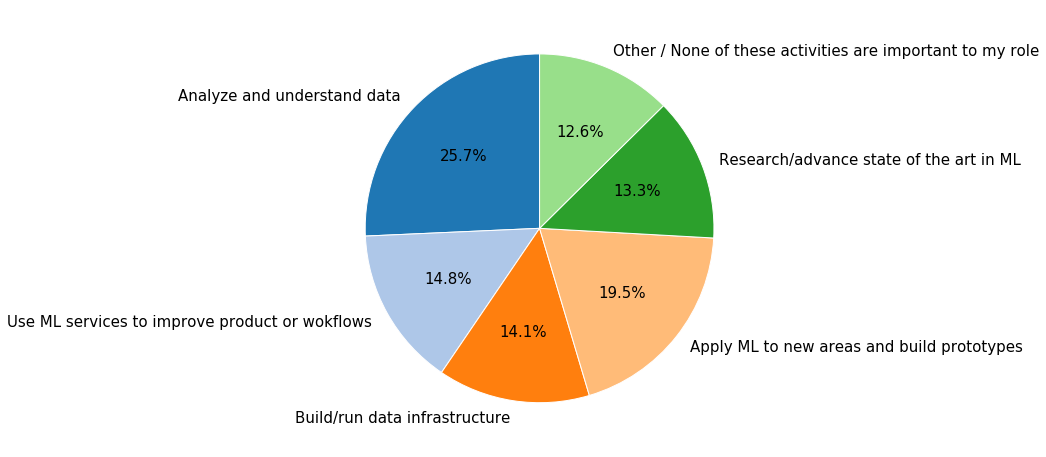

In [3]:
set_rcParams(); pie_plot_important_activities_2018(kaggleSurveyDF_2018, schemaSurveyDF_2018 )

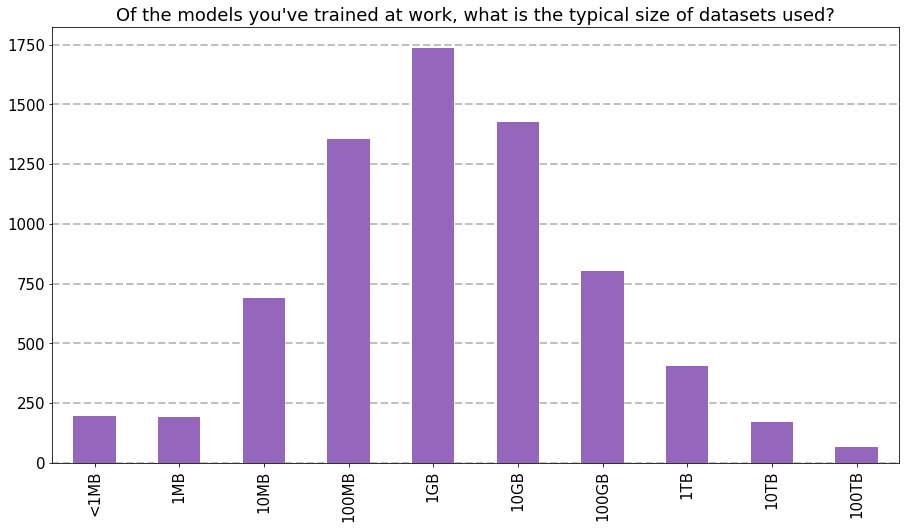

In [4]:
bar_plot_question(kaggleSurveyDF, schemaSurveyDF, 119, nTopResults = 10, 
                  newIndex = ['<1MB', '1MB', '10MB', '100MB','1GB', '10GB',  '100GB', '1TB', '10TB', '100TB'])

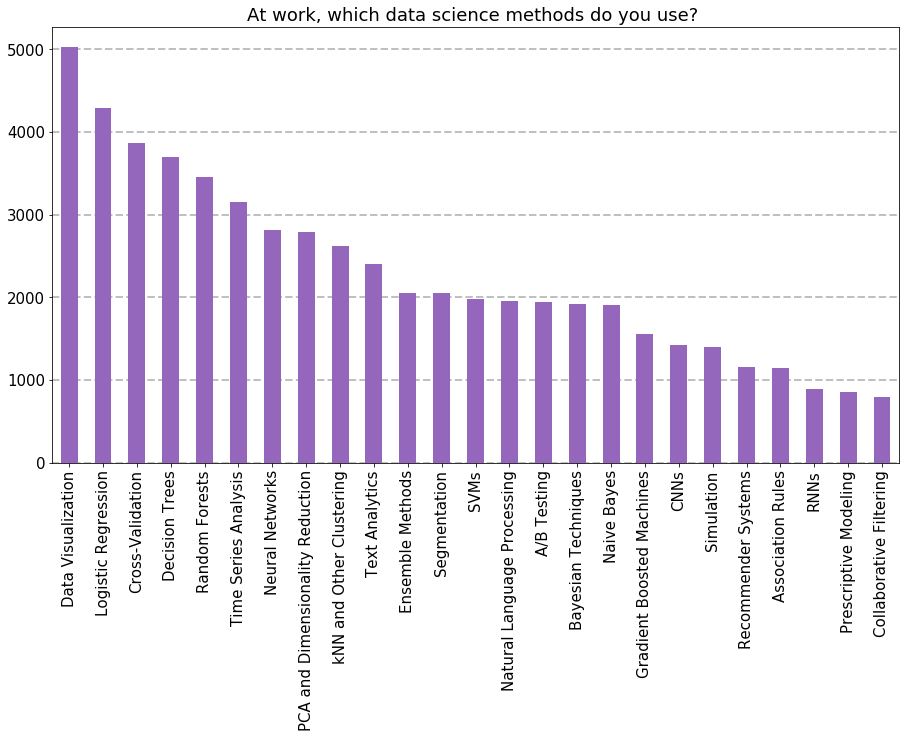

In [5]:
bar_plot_question(kaggleSurveyDF, schemaSurveyDF, 180, 25)

<Figure size 864x504 with 0 Axes>

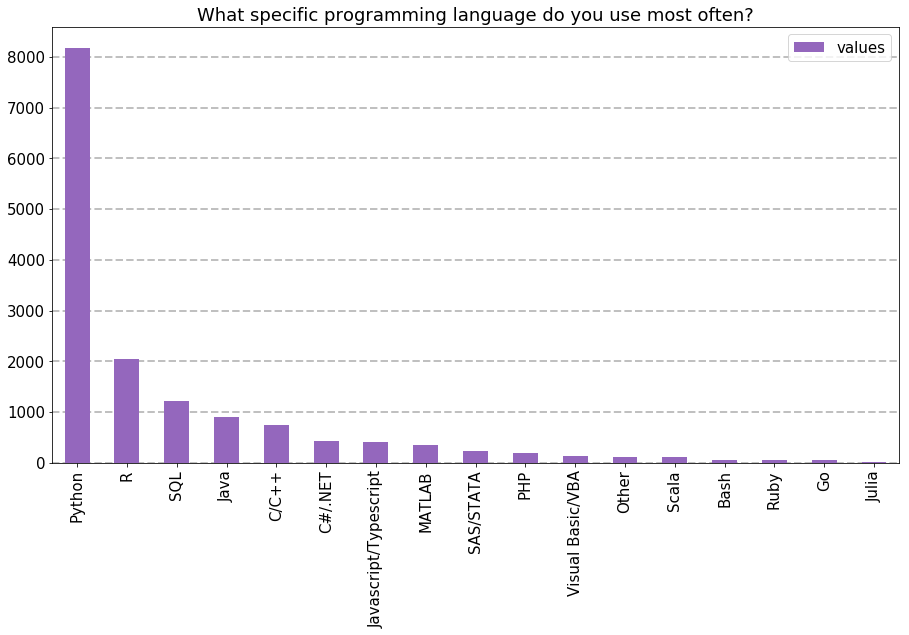

In [6]:
bar_plot_2018(kaggleSurveyDF_2018, schemaSurveyDF_2018, 17)

# Top pandas dataframe methods used 
> [ code scraped from top 1800 Kaggle notebooks ]

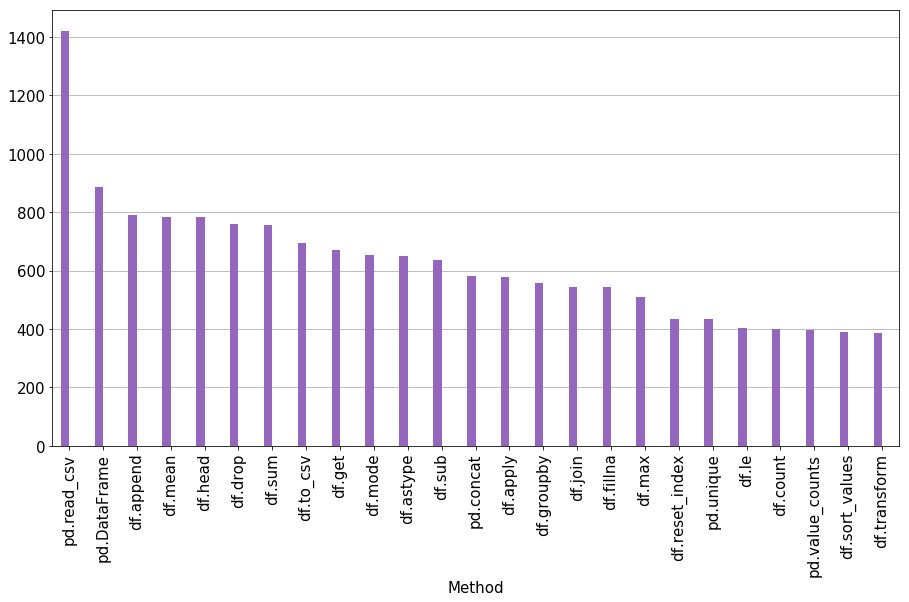

In [7]:
kaggleKernelMethodsDF.index = kaggleKernelMethodsDF['Method']
kaggleKernelMethodsDF.head(25).plot.bar(legend=False, alpha=1, color='tab:purple', rot=90); plt.gca().set_axisbelow(True); plt.gca().yaxis.grid(True)

-----
# 2. Generate Dataset [ X: features, y: labels ]

Set the size of the generated dataset -- the number of total samples is determined by this value

In [8]:
nTotalSamples = 5000000

Next we'll use <a href='https://scikit-learn.org/stable/datasets/index.html#generated-datasets'>sklearn.datasets</a> to build synthetic sub-datasets of the size we specified above. We'll build three sub-datasets and combine them together and then use a trained model to see if we can determine which of sub-dataset a sample belongs to. The three sub-datasets are built using the moons, blobs, and swiss-roll generators. These sub-datasets were selected for their distinct visual features.

In [9]:
%%time
nSamplesPerSubDataset = nTotalSamples//3

swissRollDataset = datasets.make_swiss_roll( n_samples = nSamplesPerSubDataset, noise = .005)[0]

moonsDataset = datasets.make_moons(n_samples = nSamplesPerSubDataset, noise = 0)[0]
moonsDataset = np.hstack( [moonsDataset, np.zeros( (moonsDataset.shape[0], 1) )] )*4

blobsDataset = datasets.make_blobs( n_samples = nSamplesPerSubDataset, centers = 5,  n_features = 3, 
                                    cluster_std = 0.25,  random_state = 0)[0] + [0, 1.5, 0]

CPU times: user 1.21 s, sys: 104 ms, total: 1.31 s
Wall time: 1.31 s


In [10]:
X = np.vstack([blobsDataset, swissRollDataset, moonsDataset])

In [11]:
# generate labels for classification 
blobsLabels = np.zeros(blobsDataset.shape[0])
moonsLabels = 1 * np.ones(moonsDataset.shape[0])
sRollLabels = 2 * np.ones(swissRollDataset.shape[0])

y = np.hstack( [blobsLabels, sRollLabels, moonsLabels])

In [12]:
X.shape, y.shape

((4999998, 3), (4999998,))

## 2.1 - Split Train (75%) and Test (25%) Data 
We split our combined dataset into two portions:
* **train-set** - which we'll use to optimize our model's parameters [ train-set = randomly selected 75% of total data]
* **test-set** - which we'll use to evaluate how well our trained model performs on unseen data [ test-set = remaining 25% of data ]

In [13]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.25, random_state = 0, shuffle=True)

In [14]:
len(X_train), len(X_test)

(3749998, 1250000)

## 2.2 - Visualize Data
We define a function for plotting using either matplotlib Axes3D [ default ] or  <a href='https://github.com/maartenbreddels/ipyvolume'>ipyvolume</a> for WebGL based 3D plotting -- we restrict the maximum points to plot to `maxSamplesToPlot` which has a default setting of `100000`

In [15]:
def mpl_plot_data( data, colorStack = 'purple', 
                  maxSamplesToPlot = 10000, 
                  ax3D = False, markerScale=1):
    
    nSamplesToPlot = np.min( ( len(data), maxSamplesToPlot ) )
    if not ax3D:ax3D = plt.figure(figsize=(12,12)).gca(projection='3d')
            
    if isinstance(colorStack, np.ndarray):
        colorStack = colorStack[0:maxSamplesToPlot,:]
        
    ax3D.scatter(data[0:nSamplesToPlot,0], 
                 data[0:nSamplesToPlot,1], 
                 data[0:nSamplesToPlot,2], s = 20*markerScale, c=colorStack, depthshade=False)
    
    ax3D.view_init(elev=10, azim=95)
    
def ipv_plot_data( data, colorStack = 'purple', 
                  maxSamplesToPlot = 100000, 
                  holdOnFlag = False, markerSize=.5):
    
    nSamplesToPlot = np.min( ( len(data), maxSamplesToPlot ) )
    if not holdOnFlag: ipv.figure(width=600,height=600)
        
    if isinstance(colorStack, np.ndarray):
        colorStack = colorStack[0:maxSamplesToPlot,:]

    ipv.scatter( data[0:nSamplesToPlot,0], 
                 data[0:nSamplesToPlot,1], 
                 data[0:nSamplesToPlot,2], size = markerSize, 
                 marker = 'sphere', color = colorStack)
    
    if not holdOnFlag: ipv.show()    

In [16]:
if useMatplotlib3DFlag:
    plot_data = mpl_plot_data
else:
    plot_data = ipv_plot_data    

## Sub-Datasets [ moons, blobs, swiss-roll ] 

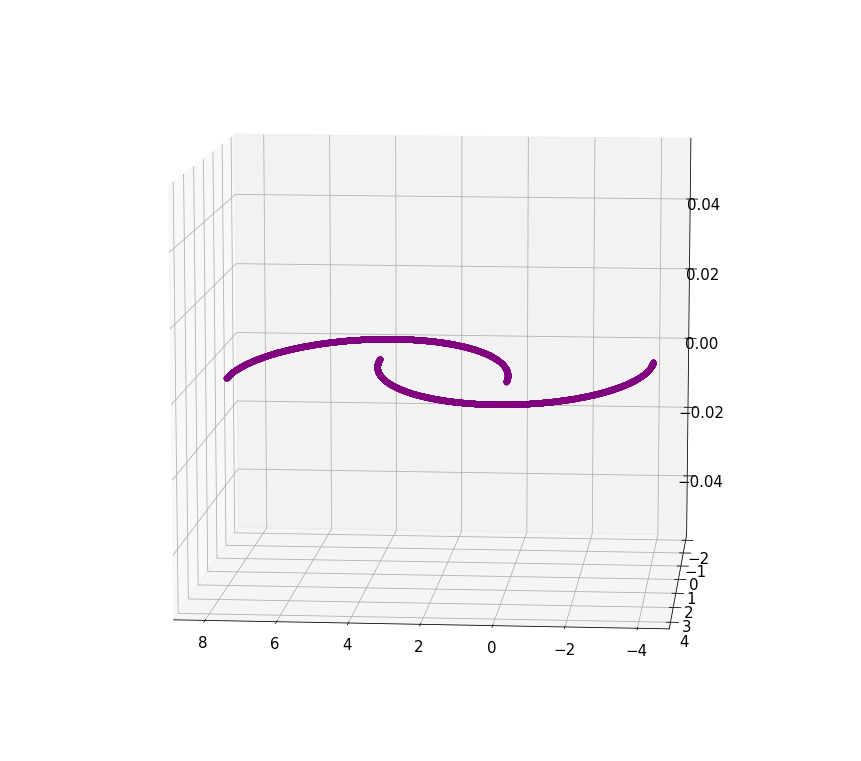

In [17]:
plot_data( moonsDataset)

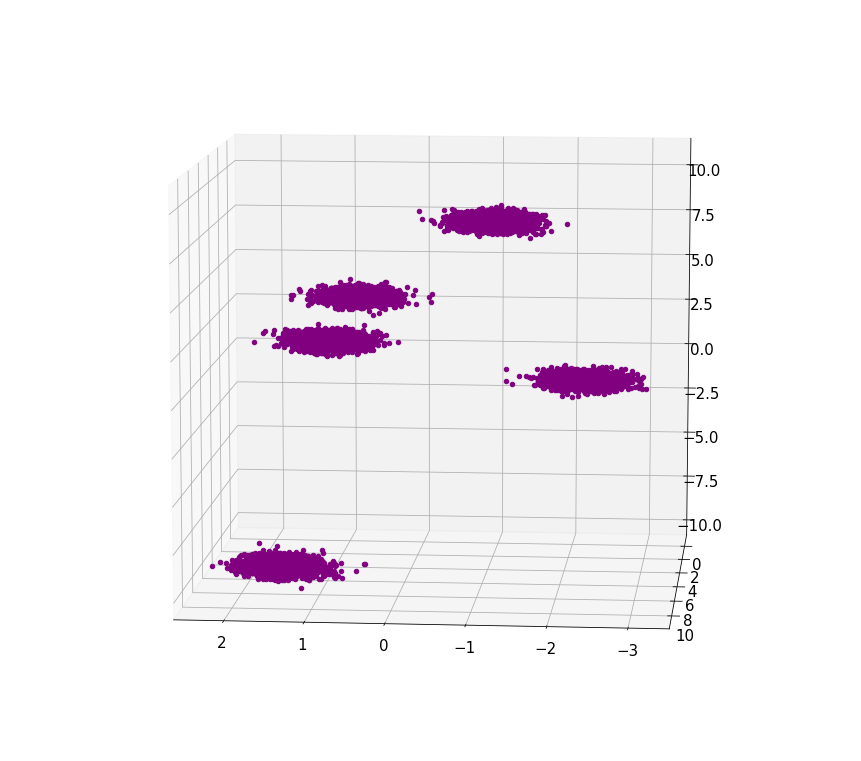

In [18]:
plot_data( blobsDataset )

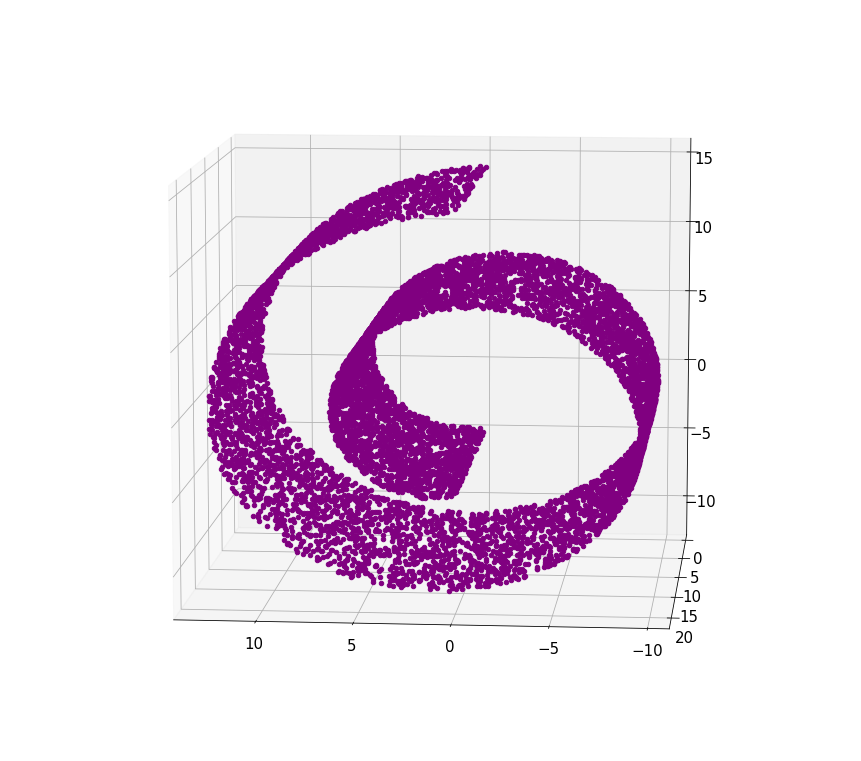

In [19]:
plot_data( swissRollDataset )

## Combined Dataset Plot
The train-set is shown in purple and the test-set is show in yellow.

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 16.9 µs


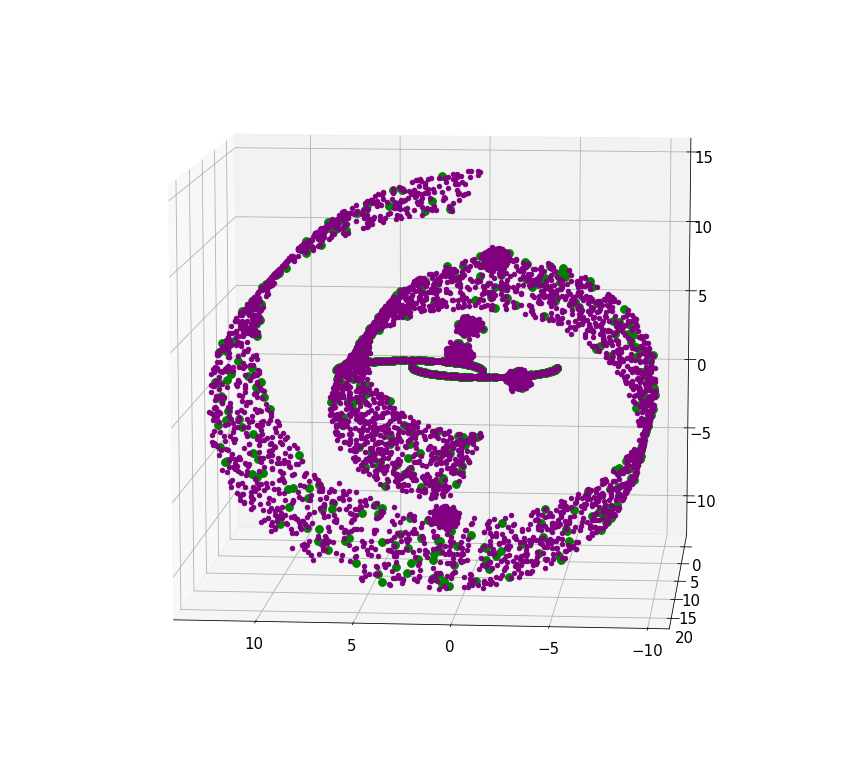

In [20]:
%time
if useMatplotlib3DFlag: 
    ax3D = plt.figure(figsize=(12,12)).gca(projection='3d')
    plot_data( X_train, 'purple', 10000, ax3D)
    plot_data( X_test, 'green', 1000, ax3D, 3)
else:
    ipv.figure()
    ipv_plot_data( X_train, 'purple', 100000, True)
    ipv_plot_data( X_test, 'green', 1000, True, 1.5)
    ipv.show()

------
# 3. ETL 
First we write the dataset to disk (as a comma separated file - CSV) so that we can subsequently demonstrate data loading.

In [21]:
%%time
pd.DataFrame(data = X_train).to_csv('X_train.csv.txt', index = False)
pd.DataFrame(data = X_test).to_csv('X_test.csv.txt', index = False)
pd.DataFrame(data = y_train).to_csv('y_train.csv.txt', index = False)
pd.DataFrame(data = y_test).to_csv('y_test.csv.txt', index = False)

CPU times: user 35.3 s, sys: 456 ms, total: 35.8 s
Wall time: 34.7 s


In [22]:
!echo 'no data\n0' > warmup.csv # write a mini csv file used to initialize cuIO kernels

## Check Size of Data on Disk 
using the default value of `nTotalSamples = 5000000` should produce a training set of `~184MBs` in size.

In [23]:
!du -h *csv.txt

62M	X_test.csv.txt
184M	X_train.csv.txt
4.8M	y_test.csv.txt
15M	y_train.csv.txt


# 3.1 - Load Data

In [24]:
%%time 
startTime = time.time()

pd_X_train = pd.read_csv('X_train.csv.txt',  delimiter=',')
pd_X_test = pd.read_csv('X_test.csv.txt',  delimiter=',')
pd_y_train = pd.read_csv('y_train.csv.txt',  delimiter=',')
pd_y_test = pd.read_csv('y_test.csv.txt',  delimiter=',')

pandasIngestionTime = time.time() - startTime

CPU times: user 3.18 s, sys: 204 ms, total: 3.38 s
Wall time: 3.38 s


In [25]:
# get column-names
f = open('X_train.csv.txt'); colNames = f.readline().strip().split(','); f.close()
# warmup rapids data ingestion engines [ cuio kernels ]
cudf.read_csv('warmup.csv')

<cudf.DataFrame ncols=1 nrows=1 >

In [26]:
%%time
startTime = time.time()

cudf_X_train = cudf.read_csv('X_train.csv.txt', delimiter=',', skiprows=1, names=colNames, dtype=['float64', 'float64', 'float64'])
cudf_X_test = cudf.read_csv('X_test.csv.txt', delimiter=',', skiprows=1, names=colNames, dtype=['float64', 'float64', 'float64'])
cudf_y_train = cudf.read_csv('y_train.csv.txt', dtype=['float64'])
cudf_y_test = cudf.read_csv('y_test.csv.txt', dtype=['float64'])

rapidsIngestionTime = time.time() - startTime

CPU times: user 248 ms, sys: 88 ms, total: 336 ms
Wall time: 922 ms


## Evaluate Load/Ingestion Speedup

In [27]:
pandasIngestionTime/rapidsIngestionTime

3.6669568772137717

# 3.2 - Transform Data ( Normalize )
Transforming a dataset is a common requirement prior to training upstream models. For each feature in the dataset we remove the mean and divide by the standard deviation -- this makes each feature behave like a normally distributed variable (e.g. gaussian with 0 mean and unit variance). 

For the data on the CPU we can use the pre-built <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html'>sklearn.preprocessing.StandardScaler</a> function.
In the case of the GPU, we demonstrate how the same transformation can be built using a custom (user defined) function written as a <a href='http://numba.pydata.org/numba-doc/0.13/CUDAJit.html'>just-in-time numba kernel</a>. 

Note that we compute the mean and standard deviation statistics on the training data, and then apply the transformation to the training and test data (i.e., the test data is never seen when computing the mean & standard deviation).

In [28]:
%%time 
startTime = time.time()

scaler = sklearn.preprocessing.StandardScaler().fit(pd_X_train) # normalize
pd_X_train = scaler.transform(pd_X_train)
pd_X_test = scaler.transform(pd_X_test)

pandasTransformTime = time.time() - startTime 

CPU times: user 256 ms, sys: 108 ms, total: 364 ms
Wall time: 362 ms


-----

In [29]:
@cuda.jit 
def gpu_scale(outputCol, colGPUArrays, colMeans, colStDevs):
    iRow = cuda.grid(1)
    if iRow < colGPUArrays.size:
        outputCol[iRow] = ( colGPUArrays[iRow] - colMeans ) / ( colStDevs + 1e-10 )

In [30]:
def standard_scaler_numba( targetDF, trainMeans = None, trainStdevs = None):
    nRows = targetDF.shape[0]
    
    blockSize = 128
    blockCount = nRows // blockSize + 1
    scaledDF = cudf.DataFrame()
    
    if trainMeans is None and trainStdevs is None:
        trainMeans = {}
        trainStdevs = {}
        
    for iColName in targetDF.columns:
        colGPUArray = targetDF[iColName].to_gpu_array()
        outputCol = cuda.device_array ( shape=(nRows), dtype=colGPUArray.dtype.name)       
        if iColName not in trainMeans.keys():
            trainMeans[iColName] = targetDF[iColName].mean()
        if iColName not in trainStdevs.keys():
            trainStdevs[iColName] = targetDF[iColName].std()
        gpu_scale[(blockCount),(blockSize)](outputCol, colGPUArray, trainMeans[iColName], trainStdevs[iColName])
        scaledDF.add_column(name=iColName, data = outputCol)    
        
    return scaledDF, trainMeans, trainStdevs

In [31]:
_, _, _ = standard_scaler_numba( cudf_X_test.copy().head(2) ) # warmup

In [32]:
%%time
startTime = time.time()

cudf_X_train, trainMeans, trainStdevs = standard_scaler_numba( cudf_X_train )
cudf_X_test, _, _ = standard_scaler_numba( cudf_X_test, trainMeans, trainStdevs )

rapidsTransformTime = time.time() - startTime

CPU times: user 36 ms, sys: 8 ms, total: 44 ms
Wall time: 73.2 ms


## Evaluate Transform Speedup

In [33]:
pandasTransformTime/rapidsTransformTime

4.943255250403877

## Verify [approximate] numerical equivalence between CPU and GPU

In [34]:
trainMeans, scaler.mean_, trainStdevs, scaler.scale_

({'0': 1.3082234224710685, '1': 5.996361720771704, '2': 0.4824967606662878},
 array([1.30822342, 5.99636172, 0.48249676]),
 {'0': 4.504864953659752, '1': 5.747277023984554, '2': 5.236244873184074},
 array([4.50486435, 5.74727626, 5.23624418]))

In [35]:
print(pd_X_test[0:2,:])

[[-0.0621235  -0.37075185 -0.09214558]
 [-0.10761707  0.34708295  1.37986425]]


In [36]:
print(cudf_X_test.head(2))

                      0                    1                    2
0   -0.0621234955274579 -0.37075180244187333 -0.09214556850235214
1  -0.10761705613328819   0.3470829051739992   1.3798640672186584


-----
# 4. - Model Building with XGBoost
-----
XGBoost is a popular algorithm for classification. It uses a sequence of decision trees built in succession such that each new tree attempts to correct the errors made by its predecessors (analogy to multiple golf swings [ each improving on the past ] to reach a target). For a deeper dive into how XGBoost works check out the following dev blog: <br>
> https://devblogs.nvidia.com/gradient-boosting-decision-trees-xgboost-cuda/

<img src='https://raw.githubusercontent.com/miroenev/rapids/master/xgboost.png' width =90%>
<center> img src: https://explained.ai/gradient-boosting/L2-loss.html </center>

## Prepare Data for Training

In [37]:
X = pd_X_train
y = pd_y_train

In [38]:
train_DataAndLabelsGPU = xgboost.DMatrix(pd_X_train, label=np.squeeze(pd_y_train))
test_DataAndLabelsGPU = xgboost.DMatrix(pd_X_test, label=np.squeeze(pd_y_test))

/conda/envs/rapids/lib/python3.7/site-packages/xgboost-0.81-py3.7.egg/xgboost/core.py:604: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/conda/envs/rapids/lib/python3.7/site-packages/xgboost-0.81-py3.7.egg/xgboost/core.py:605: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


## Specify Model Parameters

noteable parameters: [ to see all available options execute '?xgboost.XGBClassifier' in a new cell] 

* __max_depth__ : int [ default = 3 ] -- Maximum tree depth for base learners.
* __n_estimators__ : int [ default = 100 ] -- Number of boosted trees to fit.
* __n_jobs__ : int [ default = 1 ] -- Number of parallel threads used to run xgboost.

In [39]:
cpuMaxDepth = 3 # default
cpuNTrees = 100 # default

gpuMaxDepth = 15
gpuNTrees = 1

same params 4X speedup
[ CPU shallow ] deep trees 

In [40]:
nCores = !nproc --all
nCores = int(nCores[0])

paramsGPU = {
    'max_depth': gpuMaxDepth,
    'num_boost_rounds': gpuNTrees,    
    'objective': 'multi:softmax',
    'num_class': 3,
    'tree_method': 'gpu_hist',
    'random_state': 0,
}
paramsCPU = {
    'max_depth': cpuMaxDepth,
    'n_estimators': cpuNTrees,
    'tree_method': 'hist',
    'objective': 'multi:softmax',
    'num_class': 3,
    'n_jobs': nCores
}

-----
# 4.1 - Model Training

## Train on **CPU**

In [41]:
xgBoostModelCPU = xgboost.XGBClassifier(max_depth = paramsCPU['max_depth'], 
                                        n_estimators = paramsCPU['n_estimators'],
                                        tree_method = paramsCPU['tree_method'],
                                        objective = paramsCPU['objective'],
                                        num_class = paramsCPU['num_class'],
                                        n_jobs = paramsCPU['n_jobs'])

In [42]:
xgBoostModelCPU, print("using {} CPU cores for parallel xgboost training".format(nCores))

using 40 CPU cores for parallel xgboost training


(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
        max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
        n_estimators=100, n_jobs=40, nthread=None, num_class=3,
        objective='multi:softmax', random_state=0, reg_alpha=0,
        reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
        subsample=1, tree_method='hist', verbosity=1), None)

In [43]:
%%time
startTime = time.time()

xgBoostModelCPU.fit( X, y );

cpuXGBoostTime = time.time() - startTime

/conda/envs/rapids/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/conda/envs/rapids/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 25min 35s, sys: 1min 30s, total: 27min 6s
Wall time: 43.2 s


## Train on **GPU**

In [44]:
%%time
startTime = time.time()

xgBoostModelGPU = xgboost.train( dtrain = train_DataAndLabelsGPU, params = paramsGPU, num_boost_round = gpuNTrees )

gpuXGBoostTime = time.time() - startTime

CPU times: user 17.9 s, sys: 1.26 s, total: 19.2 s
Wall time: 611 ms


## Evaluate Training Speedup

In [46]:
cpuXGBoostTime/gpuXGBoostTime

70.7253860740232

-----
# 4.2 - Model Inference

## Infer/predict using Trained **CPU** Model

In [47]:
%%time
startTime = time.time()

yPredTrainCPU = xgBoostModelCPU.predict(pd_X_train)
yPredTestCPU = xgBoostModelCPU.predict(pd_X_test)

cpuXGBoostInferenceTime = time.time() - startTime

CPU times: user 1min 11s, sys: 1.53 s, total: 1min 13s
Wall time: 2.12 s


## Infer/predict using Trained **GPU** Model
> note that our objective was changed to a regression [ gpu accelerated ] so we must take care to convert each of our predictions from a continuous value to a discrete class (essentially by rounding).

In [48]:
%%time
startTime = time.time()
yPredTrainGPU = xgBoostModelGPU.predict(train_DataAndLabelsGPU)
yPredTestGPU = xgBoostModelGPU.predict(test_DataAndLabelsGPU)
gpuXGBoostInferenceTime = time.time() - startTime


CPU times: user 168 ms, sys: 40 ms, total: 208 ms
Wall time: 62.8 ms


## Evaluate Inference Speedup

In [49]:
cpuXGBoostInferenceTime/gpuXGBoostInferenceTime

33.7387679093984

-----
# 4.3 - Evaluate Accuracy
# note: for binary classification problems consider using AUC 
> from sklearn.metrics import roc_auc_score

> roc_auc_score( pd_y_test.values, np.expand_dims(yPredTestCPU,1) )


In [50]:
print( 'CPU test accuracy: {0:.6f} '.format( accuracy_score(pd_y_test, yPredTestCPU) ))
print( 'GPU test accuracy: {0:.6f} '.format( accuracy_score(pd_y_test, yPredTestGPU) ))

CPU test accuracy: 0.999911 
GPU test accuracy: 0.999952 


TODO: to increase model accuracy, increase complexity, number of trees, max_depth


In [51]:
print('\n confusion matrix on TRAIN data -- ')
print(confusion_matrix(pd_y_train, yPredTrainCPU))
print('\n confusion matrix on TEST data -- ')
print( confusion_matrix(pd_y_test, yPredTestCPU))


 confusion matrix on TRAIN data -- 
[[1249787       0     268]
 [      0 1250225       0]
 [      0      42 1249676]]

 confusion matrix on TEST data -- 
[[416525      0     86]
 [     0 416441      0]
 [     0     25 416923]]


In [52]:
print('\n confusion matrix on TRAIN data -- ')
print(confusion_matrix(pd_y_train, yPredTrainGPU))
print('\n confusion matrix on TEST data -- ')
print( confusion_matrix(pd_y_test, yPredTestGPU))


 confusion matrix on TRAIN data -- 
[[1249988       0      67]
 [      0 1250225       0]
 [     14      18 1249686]]

 confusion matrix on TEST data -- 
[[416571      0     40]
 [     0 416441      0]
 [     3     17 416928]]


# 4.4 - Visualize Model Outputs

## Visualizing a CPU boosted tree

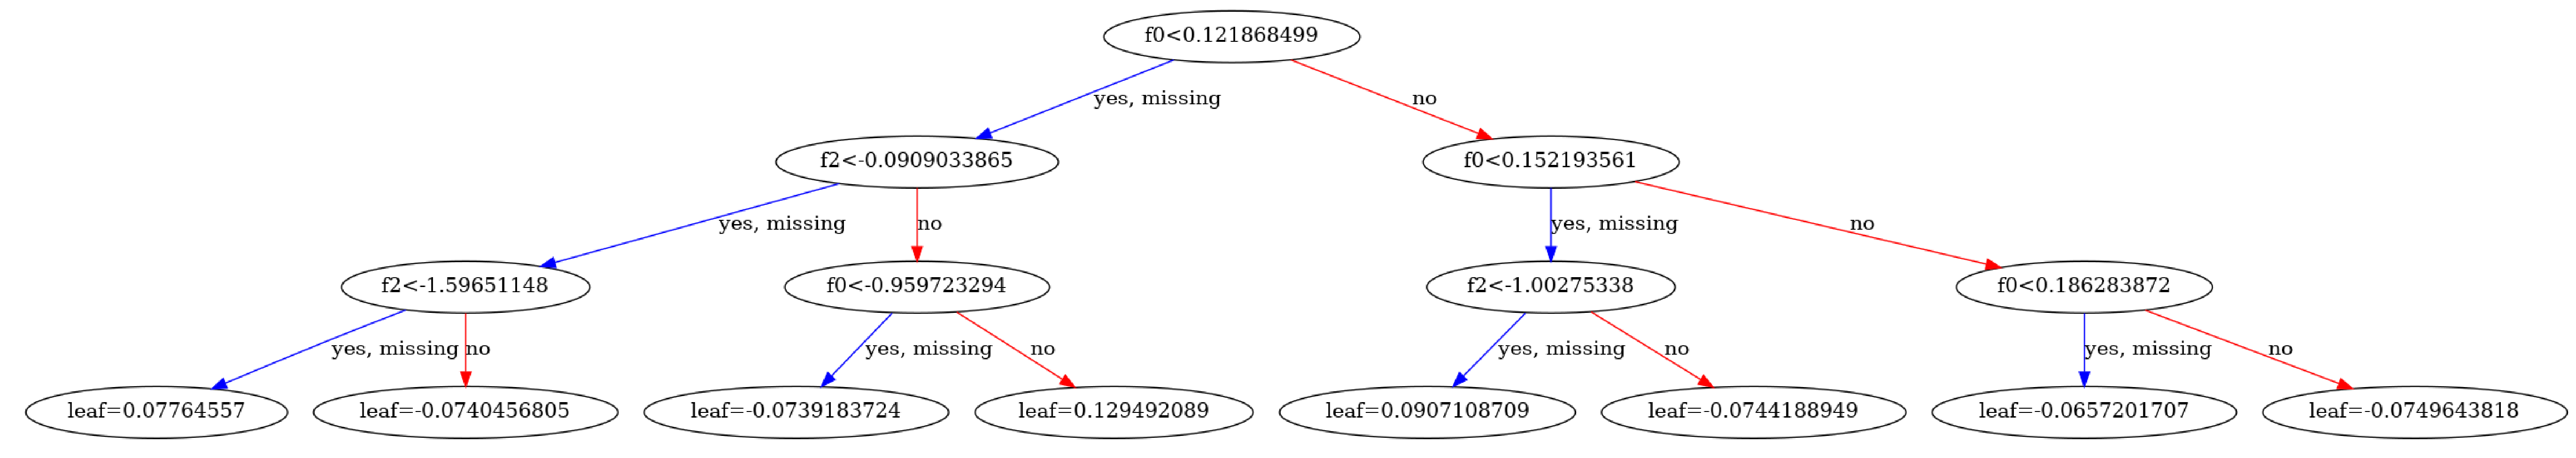

In [53]:
fig = plt.figure(figsize=(100,15))
plot_tree(xgBoostModelCPU, num_trees=0, ax=plt.subplot(1,1,1))

## Visualizing a GPU Boosted Tree

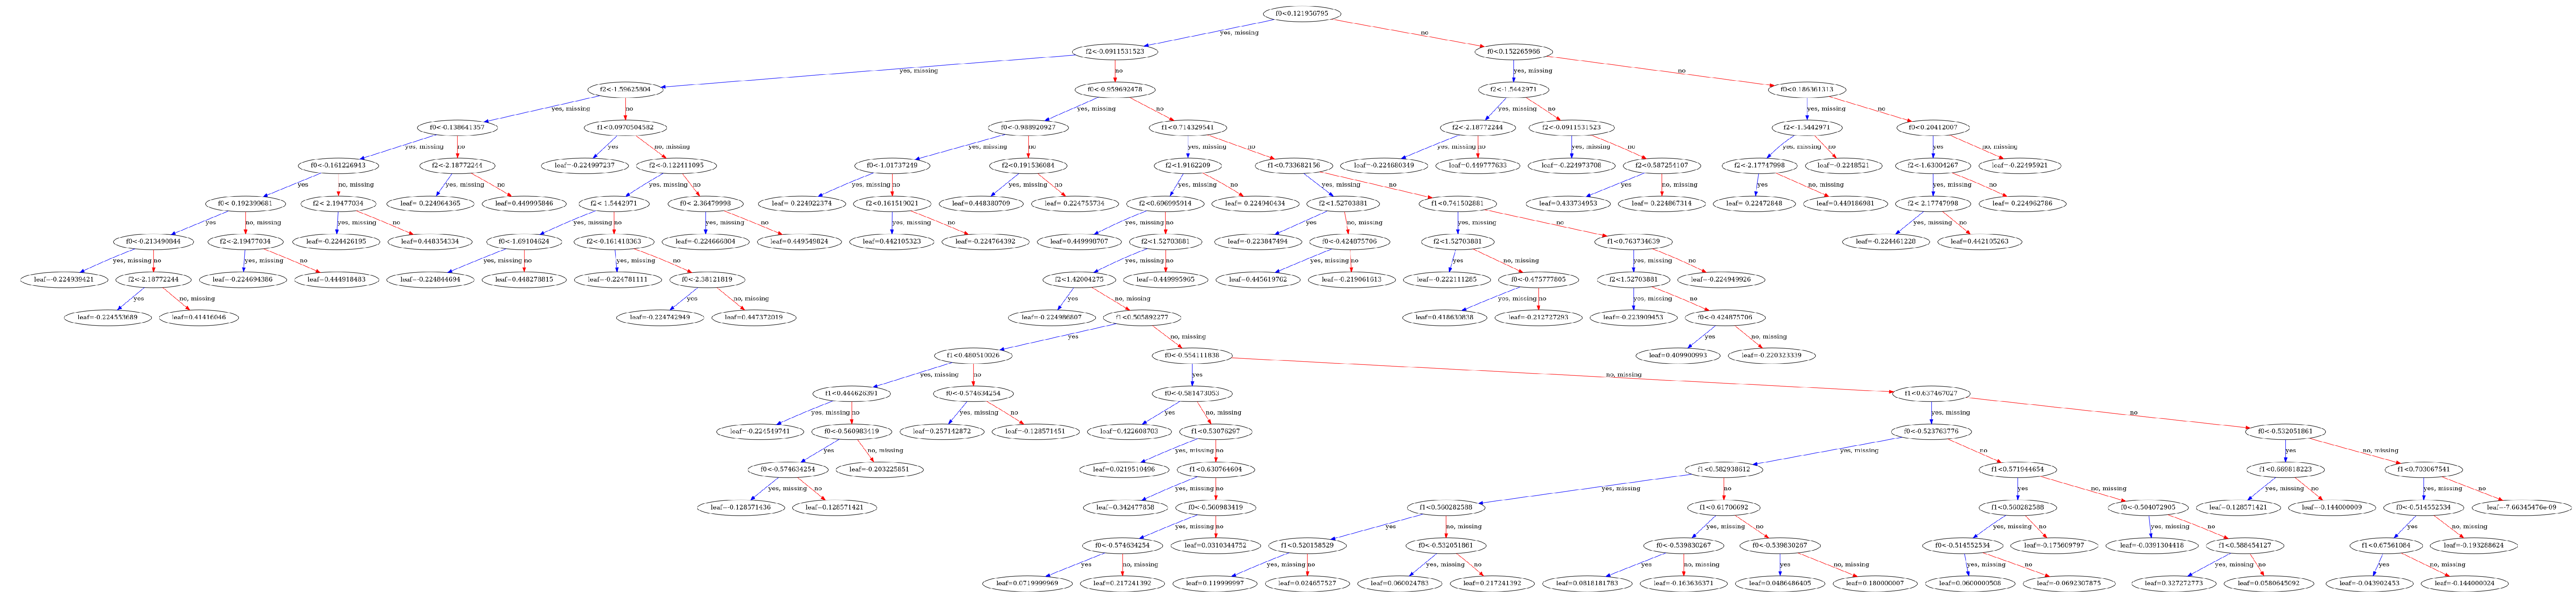

In [54]:
fig = plt.figure(figsize=(100,50))
plot_tree(xgBoostModelGPU, num_trees=0, ax=plt.subplot(1,1,1))

## Visualize Class Predictions

In [55]:
def map_colors_to_clusters_topK ( dataset, labels, topK=None, cmapName = 'tab10'):
    if topK == None:
        topK = dataset.shape[0]
    
    colorStack = np.zeros((topK, 3), dtype=np.float32)
    
    cMap = plt.get_cmap(cmapName)
    for iColor in range ( topK ):
        colorStack[iColor] = cMap.colors[ labels[iColor] ]
        
    return colorStack    

In [56]:
colorStackClassifier = map_colors_to_clusters_topK ( pd_X_test, yPredTestGPU.astype(np.int), topK=None )

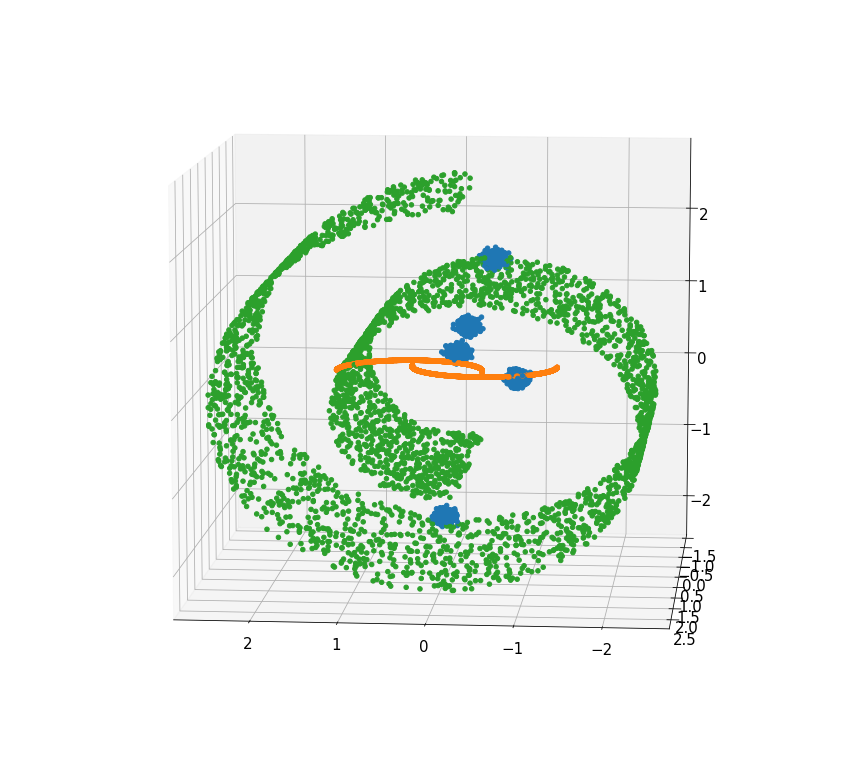

In [57]:
plot_data( pd_X_test, colorStack= colorStackClassifier)

-------
# Extensions
-------
For extensions to this work visit <a href="https://github.com/miroenev/rapids">github.com/miroenev/rapids</a> [ rapids_ml_workflow_demo_extended.ipynb ]

-----
# End [ thanks! ]